In [ ]:
#mount my google drive
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import ast
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the test df for each model

In [ ]:
one_hot_test_df = pd.read_csv('/content/drive/MyDrive/Deep Final Work/Training dfs/one_hot_test_df.csv')
index_test_df = pd.read_csv('/content/drive/MyDrive/Deep Final Work/Training dfs/index_test_df.csv')
w2v_test_df = pd.read_csv('/content/drive/MyDrive/Deep Final Work/Training dfs/w2v_test_df.csv')

##Prepare the test Data for each model

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class CalorieOneHotDataset(Dataset):
    def __init__(self, df, calorie_col='dish_calories', transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame with columns 'path', 'dish_calories',
                               and one-hot encoded ingredient columns.
            calorie_col (str): Column name for the calorie target.
            transform: Image transformations to apply.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.calorie_col = calorie_col

        # All columns that are not 'path' or the calorie column are ingredient columns.
        self.ingredient_cols = [col for col in df.columns if col not in ['path', calorie_col]]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        ingredients_vector = row[self.ingredient_cols].values.astype(np.float32)
        ingredients_vector = torch.tensor(ingredients_vector, dtype=torch.float)
        calories = torch.tensor(row[self.calorie_col], dtype=torch.float)

        return image, ingredients_vector, calories


class CalorieIndexDataset(Dataset):
    def __init__(self, df, transform=None, calorie_col='dish_calories', ingredient_col='ingredients_embedding'):
        """
        Args:
            df (pd.DataFrame): DataFrame with columns:
                - 'path': image file path.
                - ingredient_col: padded list of ingredient indices (or its string representation).
                - calorie_col: dish calorie value.
            transform: Image transformations.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.calorie_col = calorie_col
        self.ingredient_col = ingredient_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load image.
        image = Image.open(row['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        ingredient_data = row[self.ingredient_col]
        if isinstance(ingredient_data, str):
            ingredient_data = ast.literal_eval(ingredient_data)
        ingredient_indices = torch.tensor(ingredient_data, dtype=torch.long)
        calories = torch.tensor(row[self.calorie_col], dtype=torch.float)
        return image, ingredient_indices, calories

class CalorieV2wDataset(Dataset):
    def __init__(self, df, transform=None, calorie_col='dish_calories'):
        """
        Args:
            df (pd.DataFrame): DataFrame with 'path', 'ingredient_embedding', and calorie info.
            transform: Image transformations to apply.
            calorie_col (str): Column name for the calorie target.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.calorie_col = calorie_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load image.
        image = Image.open(row['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)

        embedding_data = row['ingredient_embedding']
        if isinstance(embedding_data, str):
            if ',' in embedding_data:
                embedding_data = ast.literal_eval(embedding_data)
            else:
                embedding_data = embedding_data.strip("[]")
                embedding_data = [float(x) for x in embedding_data.split()]
        ingredient_embedding = torch.tensor(embedding_data, dtype=torch.float)
        calories = torch.tensor(row[self.calorie_col], dtype=torch.float)

        return image, ingredient_embedding, calories

In [ ]:
test_dataset_onehot = CalorieOneHotDataset(one_hot_test_df, transform=transform)
test_dataset_index  = CalorieIndexDataset(index_test_df, transform=transform)
test_dataset_w2v  = CalorieV2wDataset(w2v_test_df, transform=transform)



## Load the models

In [ ]:
# classes definitions:

class CaloriePredictorOneHot(nn.Module):
    def __init__(self, ingredient_dim, hidden_dim=128):
        """
        Args:
            ingredient_dim (int): Dimension of the one-hot ingredient vector.
            hidden_dim (int): Number of hidden units in the final FC block.
        """
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        self.ingredient_fc = nn.Sequential(
            nn.Linear(ingredient_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        combined_dim = num_features + 32
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image, ingredient_vector):
        img_feat = self.resnet(image)  # shape: [batch, num_features]
        ingr_feat = self.ingredient_fc(ingredient_vector)  # shape: [batch, 32]
        combined = torch.cat([img_feat, ingr_feat], dim=1)
        out = self.fc(combined)
        return out.squeeze(1)

class CaloriePredictorIndices(nn.Module):
    def __init__(self, vocab_size, embed_dim=50, hidden_dim=128):
        """
        Args:
            vocab_size (int): Number of unique ingredients.
            embed_dim (int): Embedding dimension.
            hidden_dim (int): Hidden units in the FC layer after concatenation.
        """
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove the classification head.

        self.embedding = nn.Embedding(num_embeddings=vocab_size + 1, embedding_dim=embed_dim, padding_idx=0)

        combined_dim = num_features + embed_dim
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  .
        )

    def forward(self, image, ingredient_indices):
        image_features = self.resnet(image)
        ingr_embeds = self.embedding(ingredient_indices)  # [batch, seq_len, embed_dim]
        ingredient_features = ingr_embeds.mean(dim=1)
        combined = torch.cat([image_features, ingredient_features], dim=1)
        out = self.fc(combined)
        return out.squeeze(1)


class CaloriePredictorW2V(nn.Module):
    def __init__(self, input_embed_dim=50, hidden_dim=128):
        """
        Args:
            input_embed_dim (int): Dimension of the w2v ingredient embedding.
            hidden_dim (int): Number of hidden units in the FC regressor.
        """
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_img_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        combined_dim = num_img_features + input_embed_dim
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image, ingredient_embedding):
        image_features = self.resnet(image)
        combined = torch.cat([image_features, ingredient_embedding], dim=1)
        out = self.fc(combined)
        return out.squeeze(1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_onehot = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/calorie_predictor_resnet_onehot.pth", map_location=device)
model_index = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/calorie_predictor_resnet_indices.pth", map_location=device)
model_w2v = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/calorie_predictor_resnet_word2vec.pth", map_location=device)

model_onehot = model_onehot.to(device)
model_index = model_index.to(device)
model_w2v = CaloriePredictorW2V(input_embed_dim=50, hidden_dim=128)
model_w2v = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/calorie_predictor_resnet_word2vec.pth", map_location=device)
model_w2v = model_w2v.to(device)


model_onehot.eval()
model_index.eval()
model_w2v.eval()

<ipython-input-10-23cb8013a9c0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_onehot = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/calorie_predi

CaloriePredictorW2V(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

##Evaluate over 5 images

Evaluating samples from the test set:


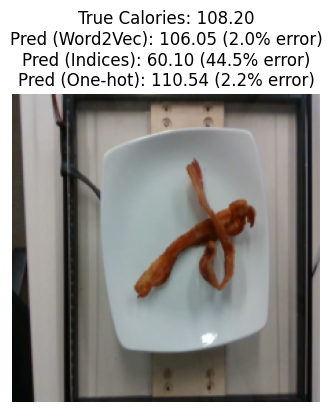

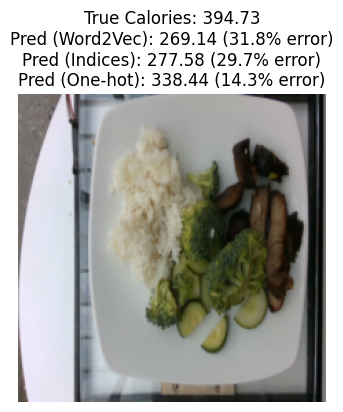

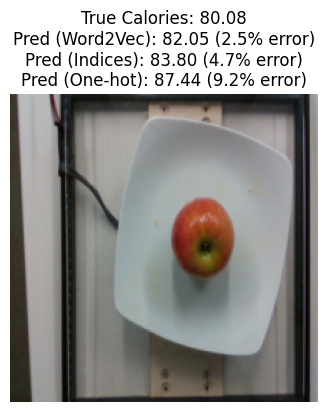

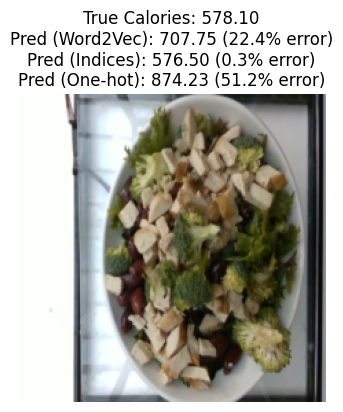

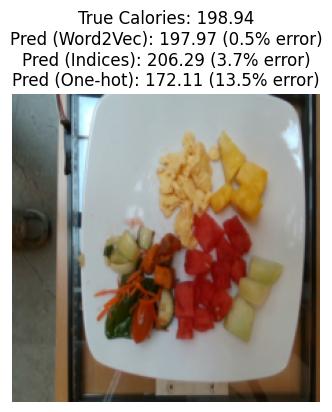

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().permute(1, 2, 0).numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# For demonstration, randomly select 5 sample indices from test_dataset_w2v.
num_samples = 5
sample_indices = random.sample(range(len(test_dataset_w2v)), num_samples)

print("Evaluating samples from the test set:")

for idx in sample_indices:
    # --- Verify that all three datasets refer to the same image ---
    path_w2v = test_dataset_w2v.df.iloc[idx]["path"]
    path_idx = test_dataset_index.df.iloc[idx]["path"]
    path_oh  = test_dataset_onehot.df.iloc[idx]["path"]

    if not (path_w2v == path_idx == path_oh):
        print(f"WARNING: Image paths differ at index {idx}!")
        print(f"  Word2Vec dataset path: {path_w2v}")
        print(f"  Index dataset path: {path_idx}")
        print(f"  One-hot dataset path: {path_oh}")

    image_w2v, ingr_embedding, true_calories = test_dataset_w2v[idx]
    image_idx, ingr_indices, _ = test_dataset_index[idx]
    image_oh, ingr_onehot, _ = test_dataset_onehot[idx]

    image_disp = denormalize(image_w2v)
    true_val = true_calories.item() if isinstance(true_calories, torch.Tensor) else true_calories

    image_input = image_w2v.unsqueeze(0).to(device)

    ingr_embedding_input = ingr_embedding.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_w2v = model_w2v(image_input, ingr_embedding_input)

    # Index-based model:
    ingr_indices_input = ingr_indices.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_idx = model_index(image_input, ingr_indices_input)

    # One-hot model:
    ingr_onehot_input = ingr_onehot.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_oh = model_onehot(image_input, ingr_onehot_input)

    # Convert predictions to scalars.
    pred_w2v_val = pred_w2v.item()
    pred_idx_val = pred_idx.item()
    pred_oh_val = pred_oh.item()

    # Calculate absolute percentage error for each model.
    def calc_error(pred, true):
        return 0 if true == 0 else abs(pred - true) / true * 100

    error_w2v = calc_error(pred_w2v_val, true_val)
    error_idx = calc_error(pred_idx_val, true_val)
    error_oh  = calc_error(pred_oh_val, true_val)

    # Display the image and predictions.
    plt.figure(figsize=(6, 4))
    plt.imshow(image_disp)
    plt.title(f"True Calories: {true_val:.2f}\n"
              f"Pred (Word2Vec): {pred_w2v_val:.2f} ({error_w2v:.1f}% error)\n"
              f"Pred (Indices): {pred_idx_val:.2f} ({error_idx:.1f}% error)\n"
              f"Pred (One-hot): {pred_oh_val:.2f} ({error_oh:.1f}% error)")
    plt.axis("off")
    plt.show()


## Evaluate over the whole test-set

In [ ]:
import torch

test_loader_w2v = DataLoader(test_dataset_w2v, batch_size=8, shuffle=False)
test_loader_indices = DataLoader(test_dataset_index, batch_size=8, shuffle=False)
test_loader_onehot = DataLoader(test_dataset_onehot, batch_size=8, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Precomputed (Word2Vec) Model Evaluation ---
model_w2v.eval()
total_abs_error_w2v = 0.0
total_percentage_error_w2v = 0.0
total_samples_w2v = 0

with torch.no_grad():
    for images, ingr_embedding, calories in test_loader_w2v:
        images = images.to(device)
        ingr_embedding = ingr_embedding.to(device)
        calories = calories.to(device)
        outputs = model_w2v(images, ingr_embedding)

        abs_error = torch.abs(outputs - calories)
        perc_error = abs_error / torch.clamp(calories, min=1e-8) * 100

        total_abs_error_w2v += torch.sum(abs_error).item()
        total_percentage_error_w2v += torch.sum(perc_error).item()
        total_samples_w2v += images.size(0)

mae_w2v = total_abs_error_w2v / total_samples_w2v
mape_w2v = total_percentage_error_w2v / total_samples_w2v

# --- Indices Model Evaluation ---
model_index.eval()
total_abs_error_index = 0.0
total_percentage_error_index = 0.0
total_samples_index = 0

with torch.no_grad():
    for images, ingr_indices, calories in test_loader_indices:
        images = images.to(device)
        ingr_indices = ingr_indices.to(device)
        calories = calories.to(device)
        outputs = model_index(images, ingr_indices)

        abs_error = torch.abs(outputs - calories)
        perc_error = abs_error / torch.clamp(calories, min=1e-8) * 100

        total_abs_error_index += torch.sum(abs_error).item()
        total_percentage_error_index += torch.sum(perc_error).item()
        total_samples_index += images.size(0)

mae_index = total_abs_error_index / total_samples_index
mape_index = total_percentage_error_index / total_samples_index

# --- One-hot Model Evaluation ---
model_onehot.eval()
total_abs_error_onehot = 0.0
total_percentage_error_onehot = 0.0
total_samples_onehot = 0

with torch.no_grad():
    for images, ingr_onehot, calories in test_loader_onehot:
        images = images.to(device)
        ingr_onehot = ingr_onehot.to(device)
        calories = calories.to(device)
        outputs = model_onehot(images, ingr_onehot)

        abs_error = torch.abs(outputs - calories)
        perc_error = abs_error / torch.clamp(calories, min=1e-8) * 100

        total_abs_error_onehot += torch.sum(abs_error).item()
        total_percentage_error_onehot += torch.sum(perc_error).item()
        total_samples_onehot += images.size(0)

mae_onehot = total_abs_error_onehot / total_samples_onehot
mape_onehot = total_percentage_error_onehot / total_samples_onehot

# --- Display the Results ---
print("Model Evaluation over the Test Set:")
print(f"Precomputed (Word2Vec) Model: MAE = {mae_w2v:.2f} calories, MAPE = {mape_w2v:.2f}%")
print(f"Indices Model: MAE = {mae_index:.2f} calories, MAPE = {mape_index:.2f}%")
print(f"One-hot Model: MAE = {mae_onehot:.2f} calories, MAPE = {mape_onehot:.2f}%")


Model Evaluation over the Test Set:
Precomputed (Word2Vec) Model: MAE = 53.02 calories, MAPE = 51.15%
Indices Model: MAE = 63.31 calories, MAPE = 66.05%
One-hot Model: MAE = 45.20 calories, MAPE = 47.15%


## Since the W2V MAPE is the lowest, we will use it for construct our final efficient+resnet_w2v model